In [1]:
%matplotlib inline
%load_ext autoreload


import torch
import torch.nn.functional as F
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
from laughter_classification.sspnet_data_sampler import SSPNetDataSampler
from laughter_prediction.feature_extractors import LibrosaExtractor
from sklearn.model_selection import train_test_split
from laughter_prediction.rnn import LibrosaFeaturesRnn
from laughter_prediction.predictors import RnnPredictor
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt


In [2]:
!mkdir -p data

## Cмотирим на данные

In [3]:
directory = 'vocalizationcorpus/data'
audio_files = list(sorted(os.listdir('vocalizationcorpus/data')))

audio_file = directory + '/' + audio_files[0]
audio_file

'vocalizationcorpus/data/S0001.wav'

(128, 474)


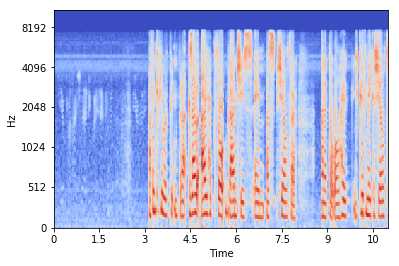

In [4]:
y, sr = librosa.load(audio_file)
S = librosa.feature.melspectrogram(y, sr)
S = librosa.power_to_db(S)

print(S.shape)
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel')

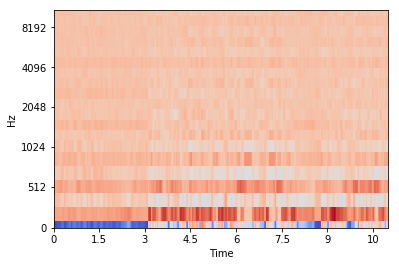

In [5]:
y, sr = librosa.load(audio_file)
S = librosa.feature.mfcc(y, sr)
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel')

In [6]:
extractor = LibrosaExtractor()
extractor.extract_features(audio_file).head()

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_010,mfcc_011,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019
0,-14.770546,-7.502573,-14.677981,-10.937127,-21.269282,-39.300535,-43.299913,-38.613908,-20.862417,-16.210959,...,7.274429,11.029847,10.672556,-0.565825,19.375721,1.419888,6.978270,-2.037510,20.511622,8.859711
1,-16.770523,-8.677541,-18.883031,-33.635306,-29.146382,-23.314792,-15.536017,-10.014064,-25.719489,-35.669000,...,-16.901669,-7.184055,-19.194132,-17.970590,12.663122,-0.107084,20.268938,1.372494,-7.076095,8.931564
2,-12.352719,-4.444362,-14.673733,-42.556730,-17.731121,-11.759801,-19.046962,-15.194353,-23.255466,-19.323618,...,-11.666725,2.564224,-4.208590,-11.211039,16.965807,16.649665,23.453795,11.212921,9.460361,-13.224893
3,-15.440580,-7.917505,-18.145880,-45.599949,-29.652522,-23.691098,-19.468875,-14.010716,-25.302332,-22.604453,...,-0.191644,9.514174,-7.796018,-7.132752,11.623116,8.058064,21.677039,-1.138147,-2.169490,-5.259990
4,-18.958624,-11.360067,-18.807546,-15.593530,-23.763246,-21.985535,-24.705120,-19.680730,-22.500579,-18.102045,...,-14.405206,-4.518877,4.056877,6.588490,14.185785,-15.692512,3.539914,12.142542,9.761851,3.887359


## Считываем признаки

In [7]:
SAMPLE_RATE = 16000
FRAME_SEC = 0.3

In [8]:
sampler = SSPNetDataSampler('vocalizationcorpus')

In [9]:
data = sampler.create_sampled_df(FRAME_SEC, save_path='data/sampled.csv')

/home/maxim/PycharmProjects/speech-ml-hw/2/homework/laughter_classification/sspnet_data_sampler.py:112: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  return pd.DataFrame.from_csv(save_path, index_col=None)


In [10]:
data

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019,IS_LAUGHTER,SNAME
0,-19.512337,-10.751633,-14.777827,-18.966939,-16.917103,-18.246705,-20.162993,-18.075304,-17.600648,-18.778584,...,8.756960,-14.857754,22.649179,-15.996658,12.870518,-10.768023,6.965929,-3.087592,0,S0001
1,-16.418212,-11.479087,-15.647148,-18.000653,-16.257974,-18.293827,-19.216450,-17.100311,-17.355976,-18.953886,...,9.974392,-17.866732,21.224710,-12.295156,15.577631,-11.913397,5.912433,-2.406997,0,S0001
2,-19.561318,-14.155631,-16.500950,-19.259373,-15.947509,-18.508480,-17.752083,-18.735773,-20.000116,-18.555955,...,11.887583,-15.699741,18.171677,-13.792290,8.600648,-10.910454,7.183778,-5.662854,0,S0001
3,-19.069293,-13.010108,-17.266277,-16.038272,-13.717408,-16.670910,-19.712922,-18.614219,-19.417061,-19.828697,...,6.627427,-9.134603,24.201275,-19.071646,13.919328,-5.860380,2.450502,-8.587574,0,S0001
4,-15.080133,-9.803062,-15.000448,-16.308712,-16.056597,-17.036844,-19.208406,-17.545893,-20.549559,-17.875918,...,12.126552,-17.691907,21.201253,-14.738738,12.562647,-8.362024,5.665779,-4.746374,0,S0001
5,-16.768311,-10.336495,-15.832604,-16.880480,-14.970650,-18.038281,-20.697990,-19.351725,-21.673575,-21.253379,...,11.975913,-12.901809,24.117082,-15.677362,14.176729,-4.046529,2.868359,-8.642527,0,S0001
6,-18.152393,-13.111996,-18.351703,-17.225439,-14.967807,-18.456091,-17.151680,-15.648074,-16.994343,-18.038206,...,7.246362,-14.432793,20.468048,-17.810742,9.385266,-9.466130,3.346170,-5.362977,0,S0001
7,-17.162352,-12.888983,-17.996707,-19.491615,-18.377252,-16.595850,-18.217371,-17.095571,-16.184384,-17.890604,...,9.661401,-15.591358,22.338917,-16.937508,8.823653,-13.398335,4.027778,-3.166383,0,S0001
8,-21.760583,-17.076791,-17.519815,-17.840089,-15.205841,-15.410737,-19.382010,-16.272773,-15.181722,-17.153874,...,6.881137,-13.332776,20.765922,-16.207669,8.292226,-13.345987,1.548566,-2.481757,0,S0001
9,-20.976208,-13.166227,-16.969717,-15.078048,-15.592011,-20.803412,-18.955738,-17.210551,-20.674733,-21.714713,...,12.389687,-14.276152,22.001954,-17.787656,13.491517,-8.972144,4.211393,-4.558085,0,S0001


In [11]:
sampler_noisy = SSPNetDataSampler('vocalizationcorpus_noisy_2')
data_noisy = sampler_noisy.create_sampled_df(FRAME_SEC, save_path='data/sampled_noisy_2.csv')

In [12]:
data_noisy

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019,IS_LAUGHTER,SNAME
0,10.439375,8.166172,1.787343,0.961609,0.518251,0.464785,5.940004,4.732757,4.939084,5.496507,...,6.693442,-11.973558,7.150050,-6.267481,10.497273,-12.915785,8.740633,9.074363,0,S0001
1,4.214703,8.075847,1.559017,-1.940547,1.403326,3.353881,7.548226,4.186003,2.652214,5.195771,...,2.727214,-13.905526,7.403936,-9.058948,9.081893,-7.995094,6.641132,3.317221,0,S0001
2,3.450489,7.706800,4.059098,1.855232,0.719113,2.182044,5.040138,5.347765,5.370654,6.265171,...,8.247667,-11.805309,6.371170,-7.856377,7.630264,-9.810210,7.772787,4.375901,0,S0001
3,5.561931,7.588067,1.510005,-1.733389,-1.299166,0.477881,4.574728,2.833029,4.859122,6.362141,...,0.230917,-12.271124,11.751942,-11.081493,4.893829,-6.404770,11.517457,3.516976,0,S0001
4,6.332487,7.019075,1.935890,2.248774,3.163043,0.984186,5.826662,3.069556,1.411427,4.045337,...,8.081160,-14.971185,5.849953,-8.608963,8.351795,-8.722728,7.937342,3.385792,0,S0001
5,6.117652,9.780912,4.205653,2.027693,0.629670,1.600355,6.365960,3.217295,0.862780,3.281168,...,5.991313,-11.880992,8.421637,-9.228018,9.534089,-5.466217,7.101127,5.614264,0,S0001
6,6.268359,8.070545,2.826578,2.210052,1.505526,2.239051,5.780330,5.425508,5.969553,6.014756,...,3.951274,-13.804472,5.858026,-6.610253,5.541875,-6.871681,5.227476,3.919196,0,S0001
7,5.988946,8.389796,3.011688,1.839174,-0.357400,2.435814,6.750822,3.307585,4.471572,5.128310,...,2.453321,-11.538826,7.357164,-4.615799,7.020939,-7.778018,5.868335,7.281755,0,S0001
8,6.183594,8.754832,3.611261,0.672525,0.547362,1.580932,3.757773,2.562096,2.818159,2.799829,...,3.758517,-13.818702,9.979484,-8.640366,6.377983,-5.681431,9.992364,7.128073,0,S0001
9,7.589022,9.450245,2.692876,1.161503,2.204125,0.454611,5.410889,2.751609,4.244760,5.225402,...,8.919660,-15.388419,7.033007,-10.901056,9.709240,-6.695360,9.332455,6.167759,0,S0001


In [13]:
laughter_precentage = np.average(data['IS_LAUGHTER']) * 100.
print(f"laughter precentage {laughter_precentage}%")

laughter precentage 3.5872435506804794%


## Обучаем модель на данных с шумом

In [14]:
def split(df, test_size=0.1, seed=0):
    np.random.seed(seed)
    df.sort_values('SNAME')
    df_by_sname = df.groupby('SNAME')
    
    records = [record for _, record in df_by_sname]
    snames  = [sname  for sname, _ in df_by_sname]
    y = [record['IS_LAUGHTER'] for record in records]
    X = [record.drop(['IS_LAUGHTER', 'SNAME'], axis=1) for record in records]
    
    y = np.array(y)
    X = np.array([x_df.values for x_df in X], dtype=np.float)
    
    X_train, X_test, y_train, y_test, snames_train, snames_test = \
        train_test_split(X, y, snames, train_size=1. - test_size, test_size=test_size)
    return  X_train, X_test, y_train, y_test, snames_train, snames_test

In [15]:
X_train, X_test, y_train, y_test, snames_train, snames_test = split(data_noisy)

In [16]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2461, 36, 148) (274, 36, 148) (2461, 36) (274, 36)


In [17]:
print(y_train[0], snames_train[0])

pd.DataFrame(X_train[0], columns=data.columns[:-2]).head()

[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] S2336


,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_010,mfcc_011,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019
0,3.688526,4.310938,3.392210,2.121922,2.088384,2.102790,-0.131036,1.115088,1.899688,3.740634,...,2.724234,-12.897148,11.049451,-2.365820,13.412796,-17.137459,8.846710,6.518349,-4.265262,-2.877157
1,6.325024,7.842447,5.637154,2.924330,2.694144,5.288957,5.905174,7.766970,5.553179,2.845893,...,9.409597,-4.665846,-1.197611,2.745664,7.851879,-8.705670,6.141375,-0.255745,5.345110,-5.443099
2,11.775905,12.552633,11.109357,10.886376,13.082940,11.253417,13.062955,19.092732,21.968246,20.956570,...,-4.866048,-7.442425,5.111979,-14.188233,14.181918,-20.814579,7.856478,-1.714793,-0.831011,-1.726254
3,10.436996,13.277370,13.436389,11.615610,11.624112,8.870857,17.096844,21.697161,22.566650,19.926751,...,-4.432448,-8.814473,2.096709,-9.683320,17.675579,-23.831961,1.379529,4.452247,-8.885002,-3.970844
4,0.313705,0.283599,-0.768698,0.296395,0.797484,1.823749,2.358381,-0.278520,1.297052,1.354024,...,16.552001,-9.244638,1.881863,4.768995,13.511652,-19.288921,12.959299,-3.803690,-4.058874,-0.202144


In [18]:
fbank_features = sum(1 for col in data_noisy.columns if col.startswith('fbank'))
mfcc_features = sum(1 for col in data_noisy.columns  if col.startswith('mfcc'))
hidden_size = 100
batch_size = 1024
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
fbank_features, mfcc_features, hidden_size, batch_size, device

(128, 20, 100, 1024, 'cuda')

In [20]:
def window_mean(arr, k=5):
    return np.convolve(arr,np.ones(k, dtype=float) / k,'valid')

In [21]:
class TrainingStats:
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.test_auc = []
        self.train_auc = []
        self.test_f1 = []
        self.train_f1 = []
        
    def plot(self):
        plt.plot(window_mean(self.train_losses), label='train_loss')
        plt.plot(window_mean(self.test_losses), label='test_loss')
        plt.legend()
        plt.show()

        plt.plot(window_mean(self.train_auc), label='train_auc')
        plt.plot(window_mean(self.test_auc), label='test_auc')
        plt.legend()
        plt.show()
        
        plt.plot(window_mean(self.train_f1), label='train_f1')
        plt.plot(window_mean(self.test_f1), label='test_f1')
        plt.legend()
        plt.show()

In [22]:
model_noisy = LibrosaFeaturesRnn(fbank_features, mfcc_features, 
                           hidden_size=hidden_size,
                           batch_size=batch_size)

model_noisy = model_noisy.to(device)
train_iter = 1


def train_model(model, X_train, y_train, X_test, y_test, batch_size, iters=100, lr=0.02, stats=None):
    if stats is None:
        stats = TrainingStats()
    
    model.set_batch_size(batch_size)
    
    y_positive = np.average(y_train)
        
    def calc_loss(pred_both, pred_mfcc, y):
        y = y.reshape(-1)
        return F.nll_loss(pred_both.reshape(-1, 2), y) + \
               F.nll_loss(pred_mfcc.reshape(-1, 2), y) 
    
    n_train = batch_size
    n_test = len(X_test)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    def calc_auc(y_actual, y_score):
        return float(roc_auc_score(y_actual.ravel(), y_score.ravel()))
    
    def calc_f1(y_actual, y_score, threshold=0.5):
        y_actual = y_actual.ravel().astype(np.int)
        y_score = y_score.ravel()
        
        y_pred = np.zeros_like(y_score, dtype=np.int)
        y_pred[y_score > threshold] = 1
        
        if np.sum(y_pred * y_actual) == 0:
            return 0.
        
        p = np.average(y_actual[y_pred == 1])
        r = np.average(y_pred[y_actual == 1])
        return float(2. / (1. / p + 1. / r))
    
    X_test_tensor = torch.tensor(X_test).float().to(device)
    y_test_tensor = torch.tensor(y_test).to(device)
    
    global train_iter
    def append_stats(train_loss, train_pred, train_y_actual):
        with torch.no_grad():
            model.set_batch_size(n_test)
            
            test_pred_both, test_pred_mfcc = model.forward(X_test_tensor, device)
            test_loss = calc_loss(test_pred_both, test_pred_mfcc, y_test_tensor)
            test_loss = test_loss.cpu().detach().numpy()
            
            test_pred = test_pred_both.cpu().detach().numpy()
            test_score = np.exp(test_pred[:,:,1])
            train_score = np.exp(train_pred[:,:,1])
            
            stats.test_losses.append(float(test_loss))
            stats.train_losses.append(float(train_loss))
            stats.test_auc.append(calc_auc(y_test, test_score))
            stats.train_auc.append(calc_auc(train_y_actual, train_score))
            stats.test_f1.append(calc_f1(y_test, test_score))
            stats.train_f1.append(calc_f1(train_y_actual, train_score))
            
    for _ in range(iters):
        model.train()
        model.zero_grad()
        model.set_batch_size(batch_size)
        
        indices = np.random.choice(n_train, batch_size, replace=False)
        X_batch = torch.tensor(X_train[indices])
        X_batch = X_batch.float().to(device)
        y_actual = torch.tensor(y_train[indices])
        y_actual = y_actual.to(device)
        
        pred_both, pred_mfcc = model.forward(X_batch, device)
        
        train_loss = calc_loss(pred_both, pred_mfcc, y_actual)
        train_loss.backward()
        optimizer.step()
        
        train_loss = train_loss.cpu().detach().numpy()
        pred_both = pred_both.cpu().detach().numpy()
        y_actual = y_actual.cpu().detach().numpy()
        
        append_stats(train_loss, pred_both, y_actual)
        
        if train_iter % 50 == 0:
            train_loss = stats.train_losses[-1]
            test_loss  = stats.test_losses[-1]
            
            train_f1 = stats.train_f1[-1]
            test_f1 = stats.test_f1[-1]
            print(f"iter {train_iter} train_loss {train_loss} test_loss {test_loss}")
            print(f"iter {train_iter} train_f1 {train_f1} test_f1 {test_f1}")
            print()
            
        if train_iter % 500 == 0:
            stats.plot()
            
        train_iter += 1
    return stats

iter 50 train_loss 0.2785874307155609 test_loss 0.2972550392150879
iter 50 train_f1 0.0 test_f1 0.0

iter 100 train_loss 0.2680148482322693 test_loss 0.2873566150665283
iter 100 train_f1 0.0 test_f1 0.0

iter 150 train_loss 0.2604054808616638 test_loss 0.279941588640213
iter 150 train_f1 0.0 test_f1 0.0

iter 200 train_loss 0.2551710605621338 test_loss 0.2748708724975586
iter 200 train_f1 0.0 test_f1 0.0

iter 250 train_loss 0.2507097125053406 test_loss 0.2705802321434021
iter 250 train_f1 0.0 test_f1 0.0

iter 300 train_loss 0.24628490209579468 test_loss 0.26653343439102173
iter 300 train_f1 0.0 test_f1 0.0

iter 350 train_loss 0.24248942732810974 test_loss 0.2631456255912781
iter 350 train_f1 0.0 test_f1 0.0

iter 400 train_loss 0.23799240589141846 test_loss 0.2590395212173462
iter 400 train_f1 0.0 test_f1 0.0

iter 450 train_loss 0.23485544323921204 test_loss 0.2567560076713562
iter 450 train_f1 0.0031645569620253164 test_f1 0.0

iter 500 train_loss 0.23204872012138367 test_loss 0.2

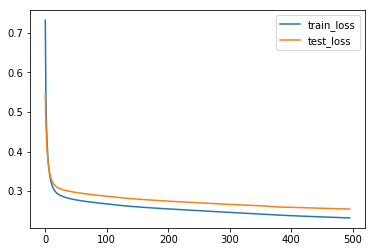

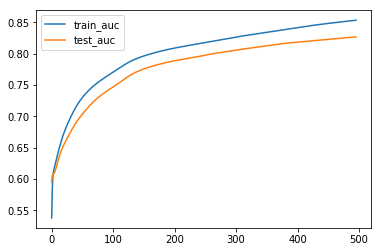

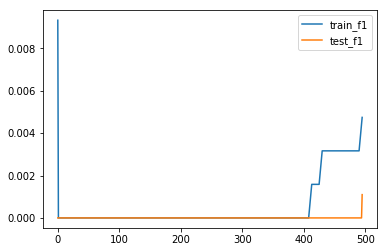

iter 550 train_loss 0.22848762571811676 test_loss 0.2512359023094177
iter 550 train_f1 0.015710919088766696 test_f1 0.032171581769437

iter 600 train_loss 0.22580337524414062 test_loss 0.24910929799079895
iter 600 train_f1 0.02805923616523772 test_f1 0.047619047619047616

iter 650 train_loss 0.22356858849525452 test_loss 0.24744254350662231
iter 650 train_f1 0.05368098159509202 test_f1 0.05729166666666667

iter 700 train_loss 0.22144731879234314 test_loss 0.2459106296300888
iter 700 train_f1 0.06534954407294834 test_f1 0.08205128205128205

iter 750 train_loss 0.2190709412097931 test_loss 0.2437528371810913
iter 750 train_f1 0.09090909090909091 test_f1 0.11970074812967582

iter 800 train_loss 0.21742111444473267 test_loss 0.24247896671295166
iter 800 train_f1 0.11029411764705882 test_f1 0.1330049261083744

iter 850 train_loss 0.21596898138523102 test_loss 0.24137651920318604
iter 850 train_f1 0.1277213352685051 test_f1 0.163855421686747

iter 900 train_loss 0.21465788781642914 test_loss

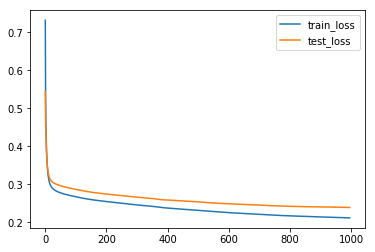

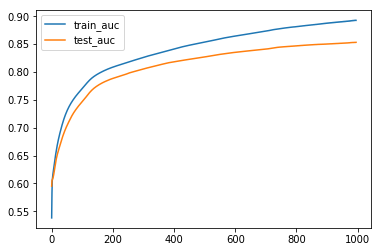

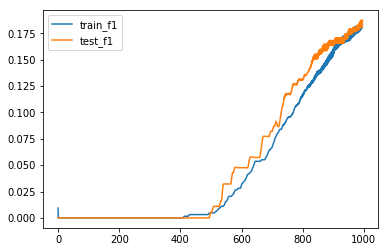

In [23]:
stats_noisy = train_model(model_noisy, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000)

iter 1050 train_loss 0.21171006560325623 test_loss 0.23865650594234467
iter 1050 train_f1 0.17287420941672524 test_f1 0.21149425287356322

iter 1100 train_loss 0.20917189121246338 test_loss 0.2371496707201004
iter 1100 train_f1 0.19126819126819125 test_f1 0.20737327188940094

iter 1150 train_loss 0.20919397473335266 test_loss 0.23766644299030304
iter 1150 train_f1 0.1910034602076124 test_f1 0.2232346241457859

iter 1200 train_loss 0.2073066532611847 test_loss 0.23620158433914185
iter 1200 train_f1 0.20383036935704513 test_f1 0.22675736961451246

iter 1250 train_loss 0.2073550820350647 test_loss 0.23700550198554993
iter 1250 train_f1 0.2020618556701031 test_f1 0.2376681614349776

iter 1300 train_loss 0.20528143644332886 test_loss 0.23530617356300354
iter 1300 train_f1 0.2150101419878296 test_f1 0.24608501118568232

iter 1350 train_loss 0.20572566986083984 test_loss 0.23599869012832642
iter 1350 train_f1 0.20887372013651873 test_f1 0.2488888888888889

iter 1400 train_loss 0.2035042345523

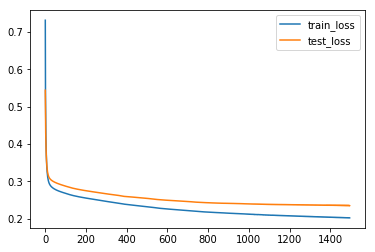

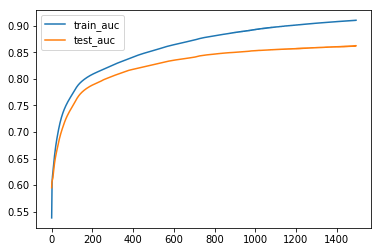

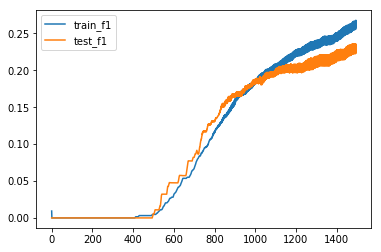

iter 1550 train_loss 0.20185533165931702 test_loss 0.23414179682731628
iter 1550 train_f1 0.2354515050167224 test_f1 0.2570806100217865

iter 1600 train_loss 0.20005270838737488 test_loss 0.23260441422462463
iter 1600 train_f1 0.25576796308503624 test_f1 0.26143790849673204

iter 1650 train_loss 0.1999969482421875 test_loss 0.23340219259262085
iter 1650 train_f1 0.2526455026455026 test_f1 0.27292110874200426

iter 1700 train_loss 0.19851380586624146 test_loss 0.23194262385368347
iter 1700 train_f1 0.26018396846254926 test_f1 0.2887473460721869

iter 1750 train_loss 0.1984180212020874 test_loss 0.23263821005821228
iter 1750 train_f1 0.2592105263157895 test_f1 0.2935010482180293

iter 1800 train_loss 0.1970166265964508 test_loss 0.23133525252342224
iter 1800 train_f1 0.2700587084148728 test_f1 0.2928870292887029

iter 1850 train_loss 0.19693918526172638 test_loss 0.23184631764888763
iter 1850 train_f1 0.273972602739726 test_f1 0.3070539419087137

iter 1900 train_loss 0.19565442204475403 

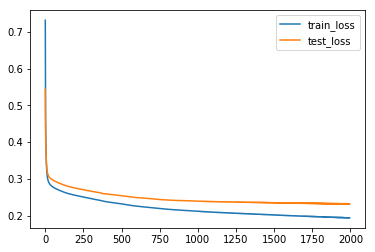

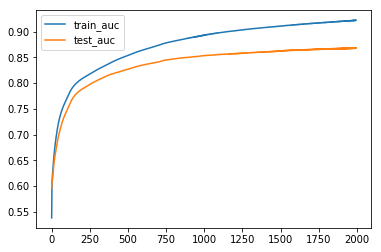

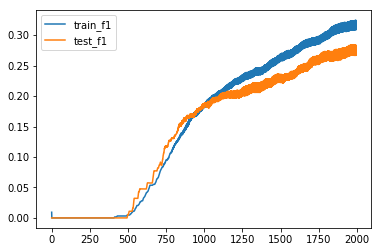

In [24]:
train_model(model_noisy, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000, stats=stats_noisy)

iter 2050 train_loss 0.19364088773727417 test_loss 0.2307289093732834
iter 2050 train_f1 0.28367875647668395 test_f1 0.32244897959183677

iter 2100 train_loss 0.1929336041212082 test_loss 0.23004379868507385
iter 2100 train_f1 0.28903225806451616 test_f1 0.3237704918032787

iter 2150 train_loss 0.1920887678861618 test_loss 0.23023882508277893
iter 2150 train_f1 0.2912371134020619 test_f1 0.32926829268292684

iter 2200 train_loss 0.1914808750152588 test_loss 0.2297111302614212
iter 2200 train_f1 0.2930591259640103 test_f1 0.3258655804480652

iter 2250 train_loss 0.19065991044044495 test_loss 0.22987841069698334
iter 2250 train_f1 0.29562982005141386 test_f1 0.3252032520325204

iter 2300 train_loss 0.19056446850299835 test_loss 0.22955971956253052
iter 2300 train_f1 0.29198966408268734 test_f1 0.32727272727272727

iter 2350 train_loss 0.18940657377243042 test_loss 0.22977390885353088
iter 2350 train_f1 0.29453376205787785 test_f1 0.3266129032258065

iter 2400 train_loss 0.189212277531623

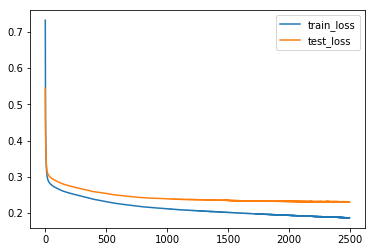

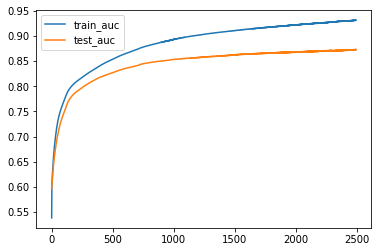

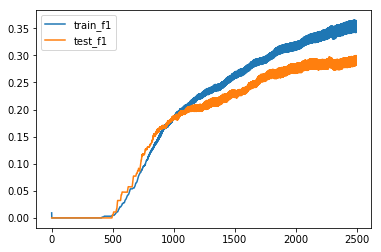

iter 2550 train_loss 0.18676955997943878 test_loss 0.22864948213100433
iter 2550 train_f1 0.30198336532309655 test_f1 0.33199999999999996

iter 2600 train_loss 0.1863049566745758 test_loss 0.22822824120521545
iter 2600 train_f1 0.30000000000000004 test_f1 0.3405940594059406

iter 2650 train_loss 0.18536311388015747 test_loss 0.2281406819820404
iter 2650 train_f1 0.311704834605598 test_f1 0.3346613545816733

iter 2700 train_loss 0.18481327593326569 test_loss 0.2278653234243393
iter 2700 train_f1 0.3079872204472843 test_f1 0.3326732673267327

iter 2750 train_loss 0.18390227854251862 test_loss 0.2277061939239502
iter 2750 train_f1 0.3185279187817259 test_f1 0.3438735177865613

iter 2800 train_loss 0.18328911066055298 test_loss 0.22756525874137878
iter 2800 train_f1 0.31725888324873097 test_f1 0.3418467583497053

iter 2850 train_loss 0.18247810006141663 test_loss 0.22722405195236206
iter 2850 train_f1 0.3268138801261829 test_f1 0.3438735177865613

iter 2900 train_loss 0.1818130761384964 te

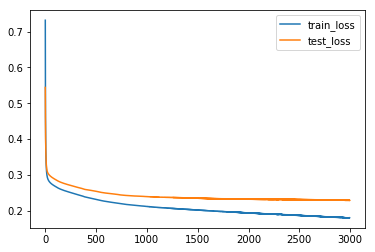

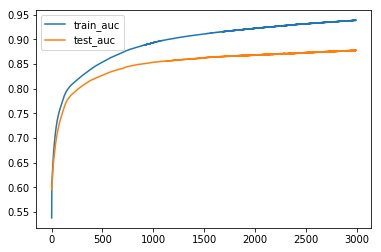

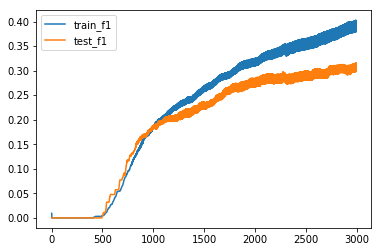

In [25]:
train_model(model_noisy, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000, stats=stats_noisy)

iter 3050 train_loss 0.18054096400737762 test_loss 0.22674165666103363
iter 3050 train_f1 0.33626097867001253 test_f1 0.357976653696498

iter 3100 train_loss 0.1795405149459839 test_loss 0.22645780444145203
iter 3100 train_f1 0.3393863494051346 test_f1 0.36504854368932044

iter 3150 train_loss 0.1794341802597046 test_loss 0.22616150975227356
iter 3150 train_f1 0.33751568381430364 test_f1 0.36504854368932044

iter 3200 train_loss 0.17826995253562927 test_loss 0.22572341561317444
iter 3200 train_f1 0.34847542003733667 test_f1 0.36504854368932044

iter 3250 train_loss 0.17769795656204224 test_loss 0.2253728210926056
iter 3250 train_f1 0.35177128651336237 test_f1 0.36504854368932044

iter 3300 train_loss 0.17699569463729858 test_loss 0.2249816656112671
iter 3300 train_f1 0.3548387096774193 test_f1 0.3643410852713178

iter 3350 train_loss 0.17621728777885437 test_loss 0.22454215586185455
iter 3350 train_f1 0.3609394313967862 test_f1 0.36363636363636365

iter 3400 train_loss 0.17557111382484

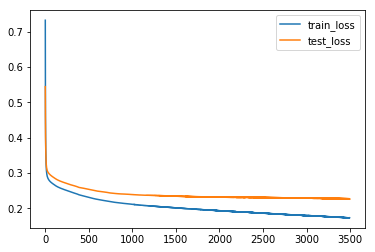

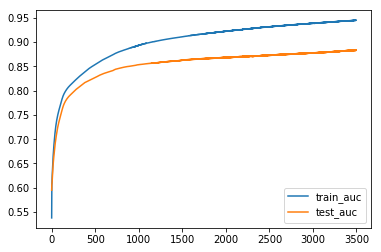

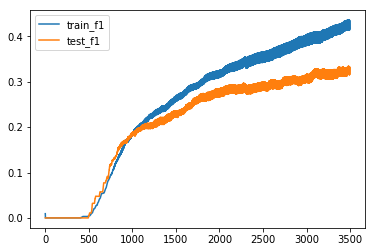

iter 3550 train_loss 0.17336535453796387 test_loss 0.22328542172908783
iter 3550 train_f1 0.37926829268292683 test_f1 0.3667953667953668

iter 3600 train_loss 0.1719861924648285 test_loss 0.22301310300827026
iter 3600 train_f1 0.39300783604581074 test_f1 0.3667953667953668

iter 3650 train_loss 0.1722235083580017 test_loss 0.22299543023109436
iter 3650 train_f1 0.38419452887537997 test_f1 0.37022900763358774

iter 3700 train_loss 0.17114558815956116 test_loss 0.2226492464542389
iter 3700 train_f1 0.38861985472154964 test_f1 0.3667953667953668

iter 3750 train_loss 0.17333796620368958 test_loss 0.22274842858314514
iter 3750 train_f1 0.3699136868064118 test_f1 0.3639846743295019

iter 3800 train_loss 0.17297038435935974 test_loss 0.22272738814353943
iter 3800 train_f1 0.3668931439159975 test_f1 0.3705103969754253

iter 3850 train_loss 0.16996827721595764 test_loss 0.2221032679080963
iter 3850 train_f1 0.39370078740157477 test_f1 0.36711281070745694

iter 3900 train_loss 0.171983316540718

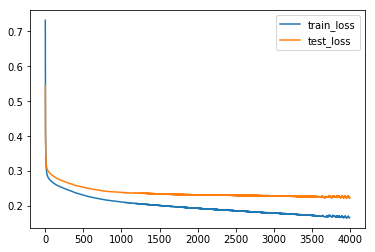

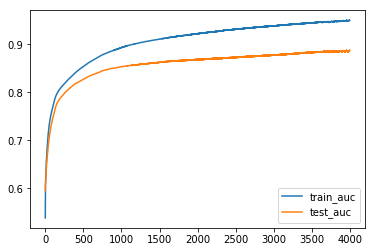

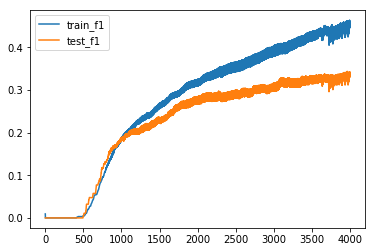

In [31]:
train_model(model_noisy, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000, stats=stats_noisy)

iter 4050 train_loss 0.1672258824110031 test_loss 0.22146277129650116
iter 4050 train_f1 0.408627920910725 test_f1 0.37236084452975043

iter 4100 train_loss 0.16944429278373718 test_loss 0.22220711410045624
iter 4100 train_f1 0.38362858888210144 test_f1 0.37593984962406013

iter 4150 train_loss 0.16844996809959412 test_loss 0.22170239686965942
iter 4150 train_f1 0.3914893617021277 test_f1 0.37735849056603776

iter 4200 train_loss 0.16527536511421204 test_loss 0.22089572250843048
iter 4200 train_f1 0.4171122994652406 test_f1 0.3682170542635659

iter 4250 train_loss 0.164240300655365 test_loss 0.22091558575630188
iter 4250 train_f1 0.4268867924528301 test_f1 0.3682170542635659

iter 4300 train_loss 0.16541653871536255 test_loss 0.2211819291114807
iter 4300 train_f1 0.4081632653061224 test_f1 0.3740458015267176

iter 4350 train_loss 0.16805300116539001 test_loss 0.2217593789100647
iter 4350 train_f1 0.38650306748466257 test_f1 0.37453183520599254

iter 4400 train_loss 0.16484537720680237 

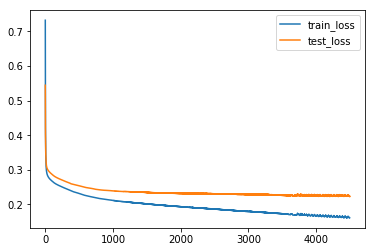

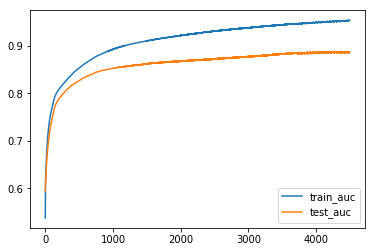

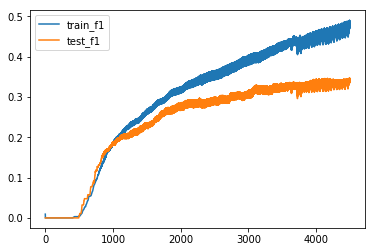

iter 4550 train_loss 0.16068227589130402 test_loss 0.22039708495140076
iter 4550 train_f1 0.44119368051492097 test_f1 0.37137330754352027

iter 4600 train_loss 0.16435113549232483 test_loss 0.2213701605796814
iter 4600 train_f1 0.40604229607250747 test_f1 0.3754646840148699

iter 4650 train_loss 0.16442348062992096 test_loss 0.2211032658815384
iter 4650 train_f1 0.4091732045866024 test_f1 0.3754646840148699

iter 4700 train_loss 0.16079363226890564 test_loss 0.22019150853157043
iter 4700 train_f1 0.42772511848341227 test_f1 0.37714285714285717

iter 4750 train_loss 0.1590379774570465 test_loss 0.2201215922832489
iter 4750 train_f1 0.44781341107871725 test_f1 0.3695238095238095

iter 4800 train_loss 0.15947479009628296 test_loss 0.22019356489181519
iter 4800 train_f1 0.4367274867569159 test_f1 0.3712121212121212

iter 4850 train_loss 0.1650667041540146 test_loss 0.2212083637714386
iter 4850 train_f1 0.39975550122249387 test_f1 0.3793738489871087

iter 4900 train_loss 0.15779724717140198

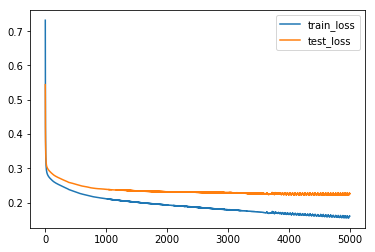

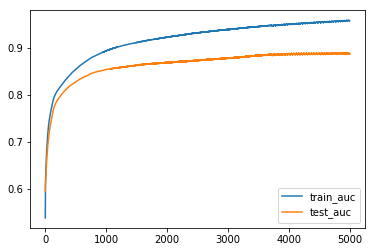

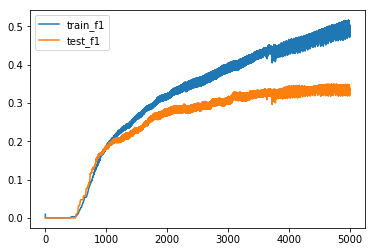

In [32]:
train_model(model_noisy, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000, stats=stats_noisy)

In [33]:
predicted_probality = RnnPredictor(model_noisy).predict_proba(X_test, device)

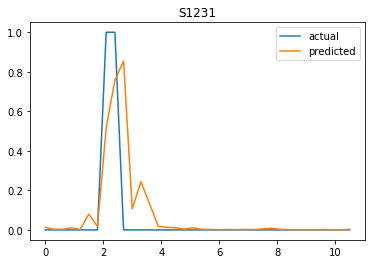

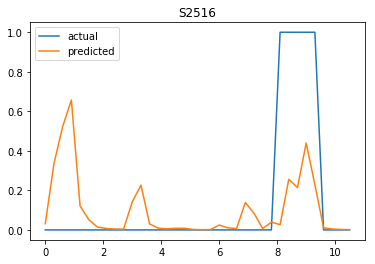

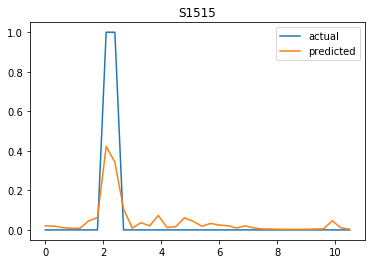

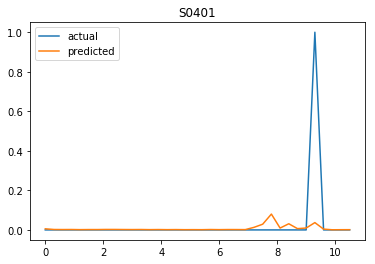

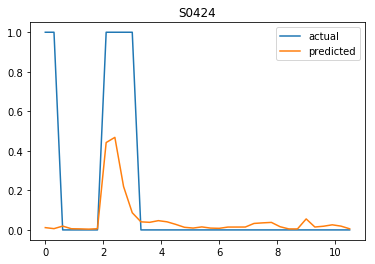

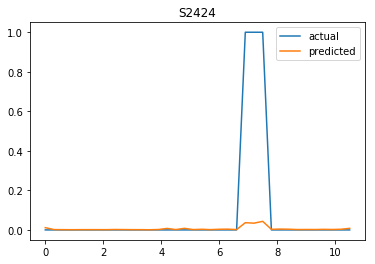

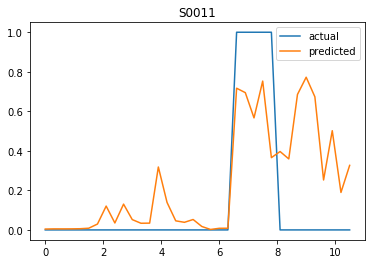

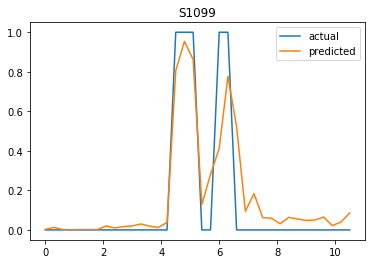

In [35]:
for sname, actual, pred in zip(snames_test[:32], y_test, predicted_probality):
    if np.sum(actual) != 0:
        plt.title(sname)
        l = len(actual)
        plt.plot(np.arange(l) * FRAME_SEC, actual, label='actual')
        plt.plot(np.arange(l) * FRAME_SEC, pred, label='predicted')
        plt.legend()
        plt.show()


## Обучаем модель на данных без добавленного шума

In [36]:
X_train, X_test, y_train, y_test, snames_train, snames_test = split(data)

In [37]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2461, 36, 148) (274, 36, 148) (2461, 36) (274, 36)


In [38]:
model_clean = LibrosaFeaturesRnn(fbank_features, mfcc_features, 
                           hidden_size=hidden_size,
                           batch_size=batch_size)

model_clean = model_clean.to(device)
train_iter = 1

iter 50 train_loss 0.2762903571128845 test_loss 0.29440897703170776
iter 50 train_f1 0.0 test_f1 0.0

iter 100 train_loss 0.2619501054286957 test_loss 0.27962225675582886
iter 100 train_f1 0.0 test_f1 0.0

iter 150 train_loss 0.2532963156700134 test_loss 0.27070415019989014
iter 150 train_f1 0.0 test_f1 0.0

iter 200 train_loss 0.24688972532749176 test_loss 0.2640857398509979
iter 200 train_f1 0.0 test_f1 0.0

iter 250 train_loss 0.24133068323135376 test_loss 0.2582215666770935
iter 250 train_f1 0.0 test_f1 0.0

iter 300 train_loss 0.23635348677635193 test_loss 0.2533465027809143
iter 300 train_f1 0.0015822784810126582 test_f1 0.005494505494505495

iter 350 train_loss 0.23203425109386444 test_loss 0.24968065321445465
iter 350 train_f1 0.006314127861089187 test_f1 0.005479452054794521

iter 400 train_loss 0.22827808558940887 test_loss 0.24659106135368347
iter 400 train_f1 0.014150943396226414 test_f1 0.01092896174863388

iter 450 train_loss 0.2252318561077118 test_loss 0.243838369846344

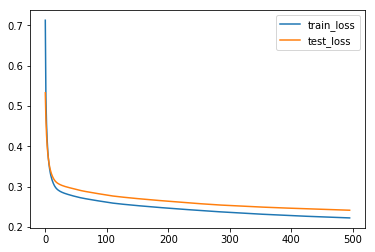

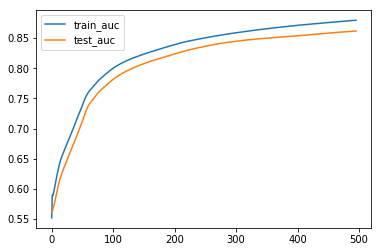

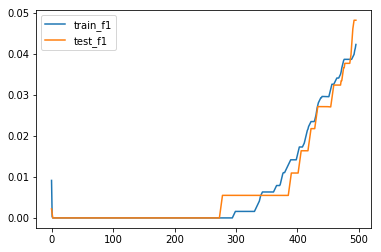

iter 550 train_loss 0.219553142786026 test_loss 0.23905691504478455
iter 550 train_f1 0.05931558935361217 test_f1 0.06842105263157895

iter 600 train_loss 0.21695902943611145 test_loss 0.2372097671031952
iter 600 train_f1 0.07796101949025487 test_f1 0.09350649350649351

iter 650 train_loss 0.21436667442321777 test_loss 0.2358863353729248
iter 650 train_f1 0.09601181683899558 test_f1 0.10282776349614396

iter 700 train_loss 0.21215438842773438 test_loss 0.2342551350593567
iter 700 train_f1 0.11127379209370425 test_f1 0.11616161616161617

iter 750 train_loss 0.20993965864181519 test_loss 0.23375684022903442
iter 750 train_f1 0.13024602026049203 test_f1 0.12562814070351758

iter 800 train_loss 0.2079867720603943 test_loss 0.23266534507274628
iter 800 train_f1 0.1511047754811119 test_f1 0.14285714285714285

iter 850 train_loss 0.20611783862113953 test_loss 0.2316817343235016
iter 850 train_f1 0.16982456140350874 test_f1 0.15724815724815724

iter 900 train_loss 0.2042194902896881 test_loss 

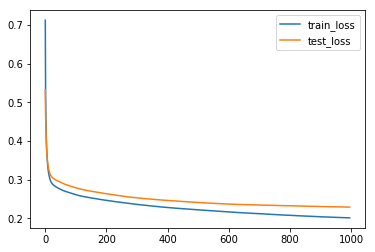

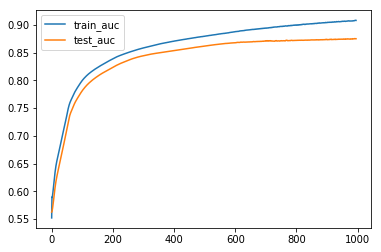

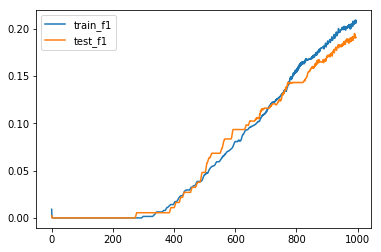

In [39]:
stats_сlean = train_model(model_clean, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000)

iter 1050 train_loss 0.20013335347175598 test_loss 0.22818869352340698
iter 1050 train_f1 0.22057834566240755 test_f1 0.19811320754716982

iter 1100 train_loss 0.19825541973114014 test_loss 0.22811025381088257
iter 1100 train_f1 0.208955223880597 test_f1 0.23094688221709006

iter 1150 train_loss 0.19718846678733826 test_loss 0.22784410417079926
iter 1150 train_f1 0.2172739541160594 test_f1 0.22632794457274827

iter 1200 train_loss 0.1953708678483963 test_loss 0.2273615002632141
iter 1200 train_f1 0.2367021276595745 test_f1 0.2460136674259681

iter 1250 train_loss 0.19427776336669922 test_loss 0.22715044021606445
iter 1250 train_f1 0.24254473161033796 test_f1 0.24036281179138325

iter 1300 train_loss 0.19306683540344238 test_loss 0.2269713580608368
iter 1300 train_f1 0.25313117996044826 test_f1 0.25225225225225223

iter 1350 train_loss 0.19223299622535706 test_loss 0.22695182263851166
iter 1350 train_f1 0.24983476536682084 test_f1 0.26548672566371684

iter 1400 train_loss 0.191194832324

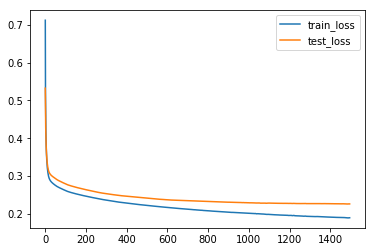

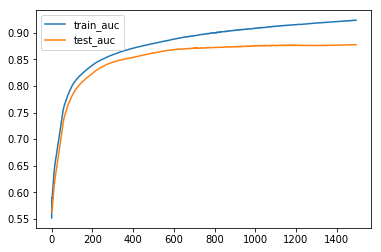

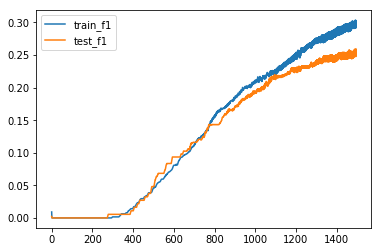

iter 1550 train_loss 0.18771563470363617 test_loss 0.22534306347370148
iter 1550 train_f1 0.2790395846852693 test_f1 0.2838709677419355

iter 1600 train_loss 0.18682080507278442 test_loss 0.22483494877815247
iter 1600 train_f1 0.2809061488673139 test_f1 0.3080168776371308

iter 1650 train_loss 0.18629004061222076 test_loss 0.22451674938201904
iter 1650 train_f1 0.2833117723156533 test_f1 0.3179916317991632

iter 1700 train_loss 0.18507952988147736 test_loss 0.22403500974178314
iter 1700 train_f1 0.2864516129032258 test_f1 0.32016632016632013

iter 1750 train_loss 0.1841084361076355 test_loss 0.2235417366027832
iter 1750 train_f1 0.2925257731958763 test_f1 0.3236514522821577

iter 1800 train_loss 0.18301540613174438 test_loss 0.22306254506111145
iter 1800 train_f1 0.2991014120667523 test_f1 0.3284823284823285

iter 1850 train_loss 0.18188166618347168 test_loss 0.22278772294521332
iter 1850 train_f1 0.30670926517571884 test_f1 0.3347107438016529

iter 1900 train_loss 0.18092939257621765 

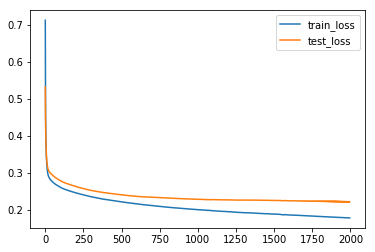

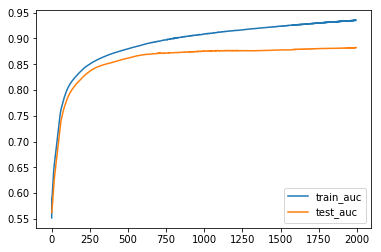

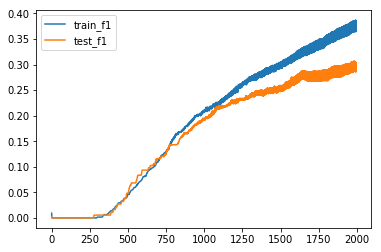

In [40]:
train_model(model_clean, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000, stats=stats_сlean)

iter 2050 train_loss 0.1779317855834961 test_loss 0.22111162543296814
iter 2050 train_f1 0.3264020163831128 test_f1 0.3481781376518219

iter 2100 train_loss 0.17709800601005554 test_loss 0.22054214775562286
iter 2100 train_f1 0.32892249527410206 test_f1 0.35412474849094566

iter 2150 train_loss 0.17610502243041992 test_loss 0.22030766308307648
iter 2150 train_f1 0.3406386975579211 test_f1 0.3548387096774193

iter 2200 train_loss 0.17530374228954315 test_loss 0.21973033249378204
iter 2200 train_f1 0.3429286608260325 test_f1 0.3614457831325301

iter 2250 train_loss 0.17426550388336182 test_loss 0.2195083200931549
iter 2250 train_f1 0.3503105590062112 test_f1 0.36

iter 2300 train_loss 0.1733674705028534 test_loss 0.21887317299842834
iter 2300 train_f1 0.3525760397268777 test_f1 0.3665338645418327

iter 2350 train_loss 0.17253074049949646 test_loss 0.21862053871154785
iter 2350 train_f1 0.3609394313967862 test_f1 0.3675889328063241

iter 2400 train_loss 0.1717834174633026 test_loss 0.2181

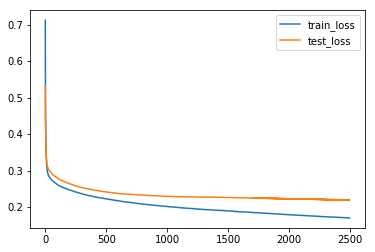

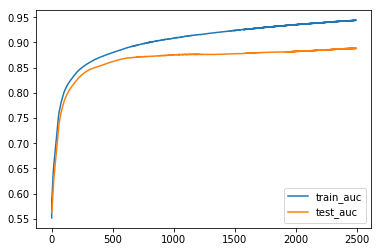

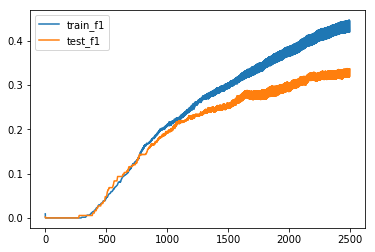

iter 2550 train_loss 0.16941773891448975 test_loss 0.2173147201538086
iter 2550 train_f1 0.37553516819571864 test_f1 0.37109374999999994

iter 2600 train_loss 0.16878928244113922 test_loss 0.21700048446655273
iter 2600 train_f1 0.38025594149908587 test_f1 0.3742690058479532

iter 2650 train_loss 0.16805368661880493 test_loss 0.2168450951576233
iter 2650 train_f1 0.38321167883211676 test_f1 0.3829787234042553

iter 2700 train_loss 0.16738095879554749 test_loss 0.21663329005241394
iter 2700 train_f1 0.3893268647665251 test_f1 0.3815028901734104

iter 2750 train_loss 0.1667604148387909 test_loss 0.21642795205116272
iter 2750 train_f1 0.39346246973365623 test_f1 0.3853564547206166

iter 2800 train_loss 0.16601219773292542 test_loss 0.21631090342998505
iter 2800 train_f1 0.4002411091018686 test_f1 0.3815028901734104

iter 2850 train_loss 0.16555671393871307 test_loss 0.21588532626628876
iter 2850 train_f1 0.3975830815709969 test_f1 0.3829787234042553

iter 2900 train_loss 0.1648314893245697

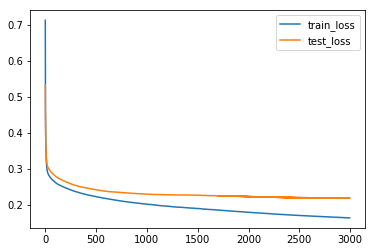

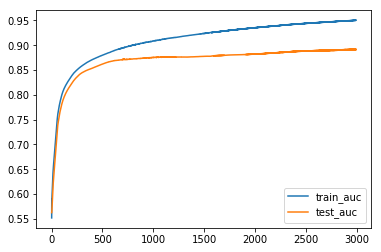

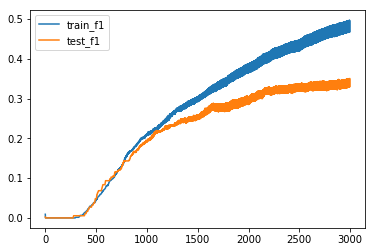

In [41]:
train_model(model_clean, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000, stats=stats_сlean)

iter 3050 train_loss 0.16287100315093994 test_loss 0.2154097557067871
iter 3050 train_f1 0.4157706093189964 test_f1 0.39230769230769236

iter 3100 train_loss 0.16218924522399902 test_loss 0.21516859531402588
iter 3100 train_f1 0.41954707985697265 test_f1 0.3938814531548757

iter 3150 train_loss 0.16158145666122437 test_loss 0.2152753472328186
iter 3150 train_f1 0.42560758743331367 test_f1 0.4

iter 3200 train_loss 0.16109424829483032 test_loss 0.21467965841293335
iter 3200 train_f1 0.4279786603438055 test_f1 0.40909090909090906

iter 3250 train_loss 0.1604168713092804 test_loss 0.21506956219673157
iter 3250 train_f1 0.4358068315665488 test_f1 0.4053537284894837

iter 3300 train_loss 0.1600971519947052 test_loss 0.21449346840381622
iter 3300 train_f1 0.4382752510336681 test_f1 0.4143126177024482

iter 3350 train_loss 0.15926456451416016 test_loss 0.2149474322795868
iter 3350 train_f1 0.4449648711943794 test_f1 0.4

iter 3400 train_loss 0.158673495054245 test_loss 0.2143963724374771
iter

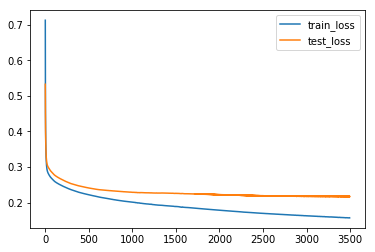

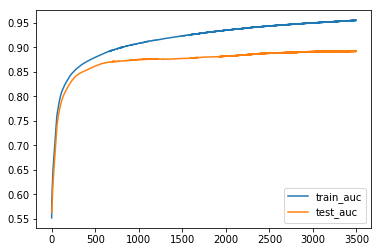

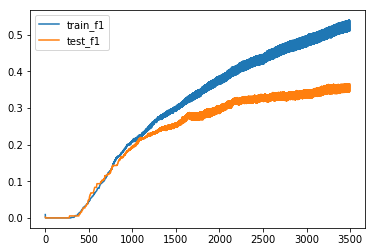

iter 3550 train_loss 0.15698295831680298 test_loss 0.214359849691391
iter 3550 train_f1 0.45930232558139533 test_f1 0.4030418250950571

iter 3600 train_loss 0.15647201240062714 test_loss 0.2137988805770874
iter 3600 train_f1 0.46100116414435394 test_f1 0.41713221601489764

iter 3650 train_loss 0.15581953525543213 test_loss 0.21398138999938965
iter 3650 train_f1 0.46554719166184133 test_f1 0.4030131826741996

iter 3700 train_loss 0.1553558111190796 test_loss 0.21348774433135986
iter 3700 train_f1 0.46279069767441866 test_f1 0.41635687732342

iter 3750 train_loss 0.15479536354541779 test_loss 0.2136349081993103
iter 3750 train_f1 0.4681344148319815 test_f1 0.4030131826741996

iter 3800 train_loss 0.15430602431297302 test_loss 0.2131863385438919
iter 3800 train_f1 0.4672463768115942 test_f1 0.4089219330855019

iter 3850 train_loss 0.15374834835529327 test_loss 0.2132534682750702
iter 3850 train_f1 0.4737146158290006 test_f1 0.40151515151515155

iter 3900 train_loss 0.15313875675201416 tes

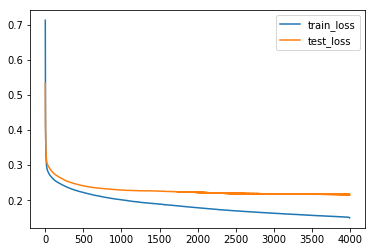

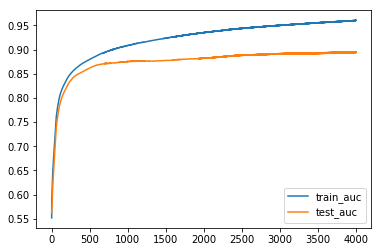

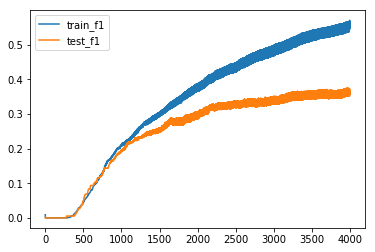

In [42]:
train_model(model_clean, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000, stats=stats_сlean)

iter 4050 train_loss 0.15194040536880493 test_loss 0.21247351169586182
iter 4050 train_f1 0.48192771084337344 test_f1 0.4074766355140187

iter 4100 train_loss 0.15103673934936523 test_loss 0.2120911031961441
iter 4100 train_f1 0.4818861414606095 test_f1 0.41929499072356213

iter 4150 train_loss 0.15116937458515167 test_loss 0.21226276457309723
iter 4150 train_f1 0.4833524684270953 test_f1 0.4067164179104477

iter 4200 train_loss 0.14975979924201965 test_loss 0.2117900848388672
iter 4200 train_f1 0.49142857142857144 test_f1 0.4186915887850468

iter 4250 train_loss 0.14995160698890686 test_loss 0.21204102039337158
iter 4250 train_f1 0.4925883694412771 test_f1 0.409683426443203

iter 4300 train_loss 0.1484431028366089 test_loss 0.211722269654274
iter 4300 train_f1 0.49772727272727274 test_f1 0.4200743494423791

iter 4350 train_loss 0.14610004425048828 test_loss 0.2114333212375641
iter 4350 train_f1 0.5293466223698782 test_f1 0.41287878787878785

iter 4400 train_loss 0.14788824319839478 te

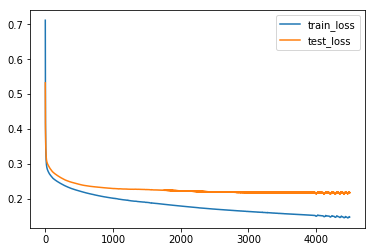

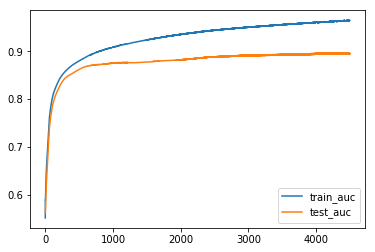

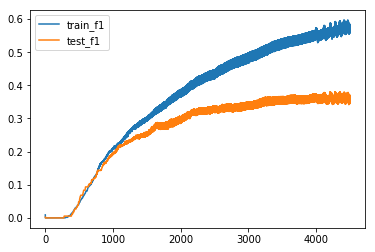

iter 4550 train_loss 0.14702117443084717 test_loss 0.21214008331298828
iter 4550 train_f1 0.5050962627406569 test_f1 0.4206642066420664

iter 4600 train_loss 0.1470530480146408 test_loss 0.21235427260398865
iter 4600 train_f1 0.5031232254400909 test_f1 0.43351548269581053

iter 4650 train_loss 0.1469859480857849 test_loss 0.212432399392128
iter 4650 train_f1 0.5065303804656445 test_f1 0.4355716878402904

iter 4700 train_loss 0.1462613046169281 test_loss 0.21202462911605835
iter 4700 train_f1 0.5090702947845804 test_f1 0.4314442413162706

iter 4750 train_loss 0.14497195184230804 test_loss 0.21193569898605347
iter 4750 train_f1 0.5140924464487034 test_f1 0.4322344322344323

iter 4800 train_loss 0.14379140734672546 test_loss 0.21150550246238708
iter 4800 train_f1 0.5220793739519285 test_f1 0.4222222222222223

iter 4850 train_loss 0.14177830517292023 test_loss 0.21142877638339996
iter 4850 train_f1 0.5388429752066115 test_f1 0.4150943396226415

iter 4900 train_loss 0.1410847008228302 test_

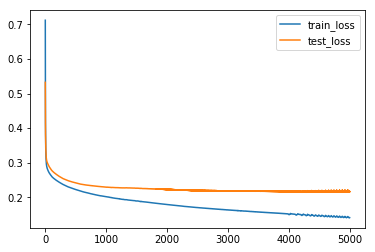

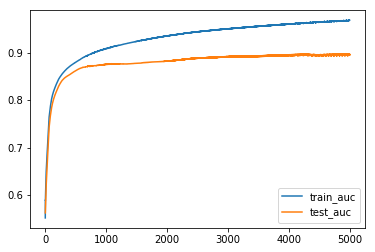

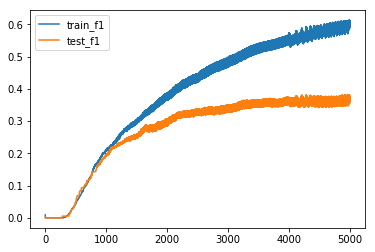

In [43]:
train_model(model_clean, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000, stats=stats_сlean)

## Сравнение моделей

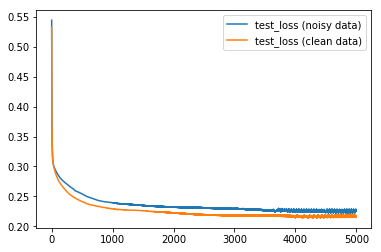

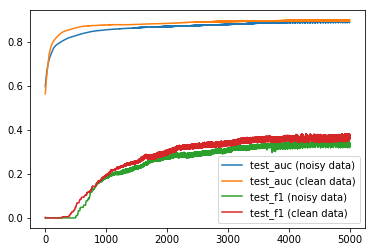

In [44]:
plt.plot(window_mean(stats_noisy.test_losses), label='test_loss (noisy data)')
plt.plot(window_mean(stats_сlean.test_losses), label='test_loss (clean data)')

plt.legend()
plt.show()

plt.plot(window_mean(stats_noisy.test_auc), label='test_auc (noisy data)')
plt.plot(window_mean(stats_сlean.test_auc), label='test_auc (clean data)')
plt.plot(window_mean(stats_noisy.test_f1), label='test_f1 (noisy data)')
plt.plot(window_mean(stats_сlean.test_f1), label='test_f1 (clean data)')

plt.legend()
plt.show()

In [45]:
_, X_test_noisy, _, y_test_noisy, _, sname_test_noisy = split(data_noisy)

In [46]:
snames_test == sname_test_noisy

True

In [47]:
scores_noisy = RnnPredictor(model_noisy).predict_proba(X_test_noisy, device)
scores_clean = RnnPredictor(model_clean).predict_proba(X_test_noisy, device)

In [48]:
from sklearn.metrics import precision_recall_curve

def plot_pr_curve(testy, scores, label=''):
    plt.title('precision recall curve')
    precision, recall, thresholds = precision_recall_curve(testy, scores)
    plt.plot(recall, precision, label=label)
    plt.xlabel('recall')
    plt.ylabel('precision')

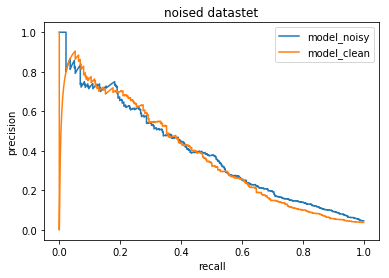

In [49]:
plot_pr_curve(y_test_noisy.ravel(), scores_noisy.ravel(), 'model_noisy')
plot_pr_curve(y_test_noisy.ravel(), scores_clean.ravel(), 'model_clean')
plt.title('noised datastet')
    
plt.legend()
plt.show()

In [50]:
_, X_test_clean, _, y_test_clean, _, sname_test_clean = split(data)

In [51]:
scores_noisy = RnnPredictor(model_noisy).predict_proba(X_test_clean, device)
scores_clean = RnnPredictor(model_clean).predict_proba(X_test_clean, device)

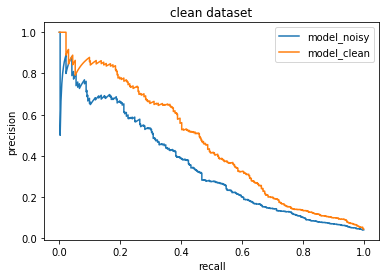

In [52]:
plot_pr_curve(y_test_noisy.ravel(), scores_noisy.ravel(), 'model_noisy')
plot_pr_curve(y_test_noisy.ravel(), scores_clean.ravel(), 'model_clean')
plt.title('clean dataset')
plt.legend()
plt.show()

## Cохранение моделей

In [53]:
torch.save(model_noisy.state_dict(), 'models/rnn_model_for_noisy_dataset.ptr')

In [54]:
torch.save(model_clean.state_dict(), 'models/rnn_model_for_clean_dataset.ptr')